In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm
# Create segments for LineCollection
from matplotlib.collections import LineCollection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity
from sklearn.cross_decomposition import PLSRegression
import umap

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/umap/distanc

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# prepare colors for plot
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec_m = sns.color_palette("dana", n_colors=27)


from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

# prepare colors for plot
colors = ['#fee6ce','#d94801']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana_f", cmap)
phasec_f = sns.color_palette("dana_f", n_colors=27)

/tmp/ipykernel_25504/1056814220.py:11: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana", cmap)
/tmp/ipykernel_25504/1056814220.py:25: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("dana_f", cmap)


## fit the model on ontogeny chron age

In [5]:
## arrange data for male
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
female_df = female_df[keep_syllables]

# for female:
f_df= female_df.groupby(['age','uuid']).mean()
# Update age value to 52 for rows with uuid in the list
# Update age value to 52 for rows with uuid in the list
uuids = ['f1d5dce5-f5cf-4b03-b07d-d9b8c1f034b0','6fa50ac7-6d49-4ef9-9059-3d90bdd8c5d4',
         'e9e05da8-fc59-40f3-a9c8-f57c492c6141','327e7fa1-2237-43d2-b25f-c1801912df33',
        '242bee8e-0ee7-45e7-8a13-678836a4cddb','552ec70f-0676-4471-8ab0-403e1fcf43e3','d6f254af-d55a-427a-96e0-c452a233cbe2']
f_df.reset_index(inplace=True)

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

f_df['age'] = f_df['age'].map(age_mapping).fillna(f_df['age'])
f_df.loc[f_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
f_df.set_index(['age', 'uuid'], inplace=True)
f_df=f_df.query('age<127')

In [6]:
# avarage per age or session
f_df= f_df.groupby(['age','uuid']).mean()
avg_f_df = f_df.groupby(['age']).mean()

# normalize the data
f_norm = mm_norm_col(f_df)
avg_f_norm = mm_norm_col(avg_f_df)

# avarage per age or session
m_df= m_df.groupby(['age','uuid']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [7]:
# Perform UMAP dimensionality reduction males ontogeny
df = m_norm.copy()
reducer = umap.UMAP(n_components=2, random_state=10, n_neighbors=50)
umap_result = reducer.fit_transform(df)

pcs_male = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs_male['age'] = df.index.get_level_values('age')
pcs_male['uuid'] = df.index.get_level_values('uuid')

In [8]:
# Perform UMAP dimensionality reduction males ontogeny
df = f_norm.copy()
reducer = umap.UMAP(n_components=2, random_state=10, n_neighbors=50, min_dist=0.1)
umap_result = reducer.fit_transform(df)

pcs_female = pd.DataFrame(umap_result, columns=['dim1','dim2'])
pcs_female['age'] = df.index.get_level_values('age')
pcs_female['uuid'] = df.index.get_level_values('uuid')

In [9]:
format_plots()

## data female beh age

In [10]:
## arrange data
## arrange data for females
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)


female_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ontogeny_females_raw_usage_df_beh_age.parquet').astype(float)
female_df = female_df[keep_syllables]
f_df= female_df.groupby(['age','uuid']).mean()

## data males beh age

In [11]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/beh_age_df/ontogeny_males_raw_usage_df_beh_age.parquet').astype(float)
male_df = male_df[keep_syllables]
m_df= male_df.groupby(['age','uuid']).mean()

## umaps

In [12]:
# Step 3: Convert 'uuid' to index for joining
filtered_pcs = pcs_male[pcs_male['uuid'].isin(m_df.index.get_level_values('uuid'))]
filtered_pcs.set_index('uuid', inplace=True)
# Step 4: Prepare df2 for joining (ensure 'uuid' is the index and 'age' is a level of the index)
df2=m_df.copy()
df2_indexed = df2.reset_index().set_index('uuid')
filtered_pcs = filtered_pcs.join(df2_indexed['age'].rename('beh_age'), on='uuid')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


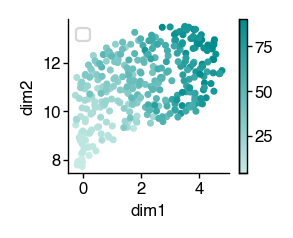

In [13]:
age_pc = filtered_pcs.groupby('beh_age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)

# Scatter plot
im = ax.scatter(
    x=filtered_pcs['dim1'], y=filtered_pcs['dim2'], 
    c=filtered_pcs['beh_age'], 
    cmap=cmm,
    s=3,
)

# Add colorbar
cb = fig.colorbar(im, ax=ax)
tick_values = [10,20,30,40,50]
# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

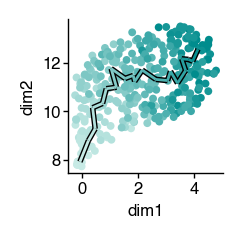

In [14]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1, 1)
im=sns.scatterplot(data=filtered_pcs, x='dim1',y='dim2',hue='beh_age',palette=cmm, legend=False, s=8, edgecolor='none')

#Create segments for LineCollection
points = np.array([age_pc['dim1'], age_pc['dim2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['dim1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)
# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

sns.despine()

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ '07_20_UMAP_male_n50.pdf')

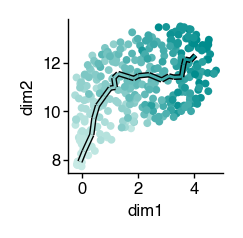

In [16]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1, 1)
im=sns.scatterplot(data=filtered_pcs, x='dim1',y='dim2',hue='beh_age',palette=cmm, legend=False, s=8, edgecolor='none')

# Convert to DataFrame for easier rolling operation
df = pd.DataFrame(age_pc)

# Apply rolling window average
window_size = 2  # Adjust the window size as needed
df_smooth = df.rolling(window=window_size, min_periods=1, center=True).mean()

# Create segments for LineCollection from the smoothed data
points = np.array([df_smooth['dim1'], df_smooth['dim2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmm, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(df_smooth['dim1'])))

# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)

# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

sns.despine()

In [17]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ '07_20_UMAP_male_n50_smoothen.pdf')

In [18]:
## for females:

In [19]:
# Step 3: Convert 'uuid' to index for joining
filtered_pcs = pcs_female[pcs_female['uuid'].isin(f_df.index.get_level_values('uuid'))]
filtered_pcs.set_index('uuid', inplace=True)
# Step 4: Prepare df2 for joining (ensure 'uuid' is the index and 'age' is a level of the index)
df2=f_df.copy()
df2_indexed = df2.reset_index().set_index('uuid')
filtered_pcs = filtered_pcs.join(df2_indexed['age'].rename('beh_age'), on='uuid')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


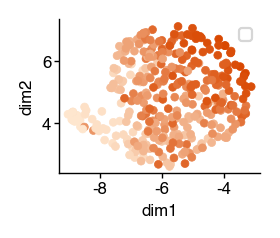

In [20]:
age_pc = filtered_pcs.groupby('beh_age').mean()

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1.3, 1)

# Scatter plot
im = ax.scatter(
    x=filtered_pcs['dim1'], y=filtered_pcs['dim2'], 
    c=filtered_pcs['beh_age'], 
    cmap=cmf,
    s=8,
    linewidth =0.25,
)

# Customize the plot
sns.despine()
#plt.title('UMAP Plot of Data females')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.legend()
plt.show()

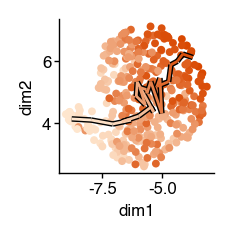

In [21]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1, 1)
im=sns.scatterplot(data=filtered_pcs, x='dim1',y='dim2',hue='beh_age',palette=cmf, legend=False, s=8, edgecolor='none')
#Create segments for LineCollection
points = np.array([age_pc['dim1'], age_pc['dim2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(age_pc['dim1'])))
# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)
# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

sns.despine()

In [22]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ '07_20_UMAP_female_n50.pdf')

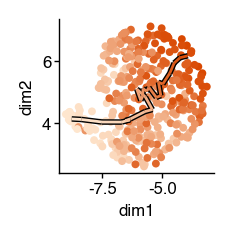

In [23]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches(1, 1)
im=sns.scatterplot(data=filtered_pcs, x='dim1',y='dim2',hue='beh_age',palette=cmf, legend=False, s=8, edgecolor='none')

# Convert to DataFrame for easier rolling operation
df = pd.DataFrame(age_pc)

# Apply rolling window average
window_size = 2  # Adjust the window size as needed
df_smooth = df.rolling(window=window_size, min_periods=1, center=True).mean()

# Create segments for LineCollection from the smoothed data
points = np.array([df_smooth['dim1'], df_smooth['dim2']]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object
lc = LineCollection(segments, cmap=cmf, norm=plt.Normalize(0, 1),linewidth=1)
lc.set_array(np.linspace(0, 1, len(df_smooth['dim1'])))

# Create the outer black line collection
black_lc = LineCollection(segments, colors='black', linewidth=2)



# Add the black line collection to the plot
ax.add_collection(black_lc)

# Add line collection to the plot
ax.add_collection(lc)
ax.autoscale()

sns.despine()

In [24]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ '07_20_UMAP_female_n50_smoothen.pdf')